In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import os

from utils import *
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torchviz import make_dot, make_dot_from_trace

In [13]:
torch.manual_seed(37)
np.random.seed(37)

plt.rcParams["figure.figsize"] = (15, 15)
torch.autograd.set_detect_anomaly(True)

device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [14]:
class SumMNISTDataset(Dataset):
    def __init__(self, root, blanks, sum_digit, size, transforms):
        path = os.path.join(root, "train")
        image_file, label_file = os.listdir(path)
        image_path = os.path.join(path, image_file)
        label_path = os.path.join(path, label_file)

        images = load_images(image_path)
        labels = load_labels(label_path)

        add_blank(images, labels, blanks)
        self.images, self.labels = sum_dataset(images, labels, sum_digit, size)
        self.sum_digit = sum_digit
        self.transforms = transforms

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        images = self.images[idx]
        labels = self.labels[idx]

        images = torch.tensor(images, dtype=torch.float).reshape(
            self.sum_digit, 1, 28, 28
        )
        labels = torch.tensor(labels, dtype=torch.int)

        if self.transforms:
            images = self.transforms(images)

        return images, labels

In [15]:
batch_size = 128
digit_num = 2
label_num = 9 * digit_num + 1
data_size = 120000
root = r"C:\Users\trand\longg\code\python\deep learning\mnist\pytorch"

dataset = SumMNISTDataset(
    root + "\mnist",
    0,
    digit_num,
    data_size,
    transforms.Compose([transforms.Grayscale(), transforms.Normalize(127.5, 127.5)]),
)

dataloader = DataLoader(dataset, batch_size, True, drop_last=True)

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
C:\Users\trand\AppData\Local\Temp\ipykernel_27076\3814528119.py:8: SyntaxWarning: invalid escape sequence '\m'
  root + "\mnist",


In [16]:
def plot_data(data, row, col):
    images, labels = data
    digit_num = images.shape[1]

    fig, axes = plt.subplots(row, col * (digit_num + 1), figsize=(15, row))
    data_acc = 0
    i = 0

    axes = axes.flatten()
    for a, ax in enumerate(axes):
        if i < digit_num:
            ax.imshow(images[data_acc][i], cmap="gray")
            i += 1
        else:
            ax.text(
                0.5,
                0.5,
                labels[data_acc],
                fontsize=150 / (row * col),
                ha="center",  # Horizontal alignment: center
                va="center",  # Vertical alignment: center
                transform=ax.transAxes,
            )  # Use axis coordinates (0 to 1)
            data_acc += 1
            i = 0
        ax.axis("off")

    fig.tight_layout()

-1.0


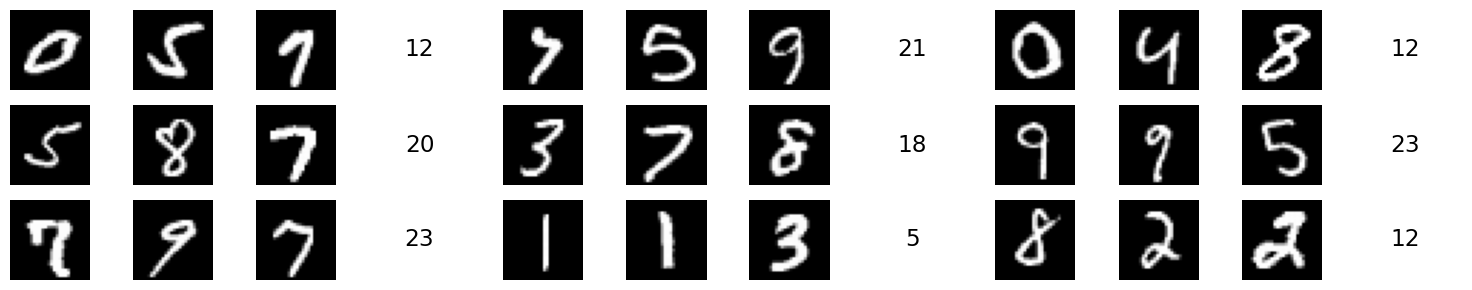

In [17]:
images_view, labels_view = next(iter(dataloader))[:9]
images_view = images_view.detach().numpy()
images_view = np.transpose(images_view, axes=(0, 1, 3, 4, 2))
labels_view = labels_view.numpy()
plot_data((images_view, labels_view), 3, 3)
print(images_view.min())

In [18]:
class Generator(nn.Module):
    def __init__(self, latent_dim, filter_num, label_num, embed_num=50, bias=False):
        super().__init__()
        self.lrelu = nn.LeakyReLU(0.2)
        self.conv1 = nn.ConvTranspose2d(latent_dim, filter_num * 4, 7, 1, 0, bias=bias)
        self.bnorm1 = nn.BatchNorm2d(filter_num * 4)

        self.embed = nn.Embedding(label_num, embed_num)
        self.lin2 = nn.Linear(embed_num, 49, bias=bias)

        self.conv2 = nn.ConvTranspose2d(
            filter_num * 4 + 1, filter_num * 2, 4, 2, 1, bias=bias
        )
        self.bnorm2 = nn.BatchNorm2d(filter_num * 2)

        self.conv3 = nn.ConvTranspose2d(filter_num * 2, 1, 4, 2, 1, bias=bias)

        self.conv3 = nn.ConvTranspose2d(filter_num * 2, 1, 4, 2, 1, bias=bias)

    def forward(self, x, y):
        y1 = self.embed(y)
        y2 = self.lin2(y1)
        y3 = y2.reshape(-1, 1, 7, 7)

        x1 = self.conv1(x)
        x2 = self.bnorm1(x1)
        x3 = self.lrelu(x2)

        x4 = torch.cat((x3, y3), dim=1)

        x5 = self.conv2(x4)
        x6 = self.bnorm2(x5)
        x7 = self.lrelu(x6)

        logits = self.conv3(x7)
        out = nn.functional.tanh(logits)

        return out

In [19]:
class Discriminator(nn.Module):
    def __init__(self, filter_num, label_num, embed_num=50, bias=False):
        super().__init__()
        self.filter_num = filter_num
        self.label_num = label_num
        self.embed_num = embed_num
        self.bias = bias

        self.lrelu = nn.LeakyReLU(0.2)
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(2, filter_num, 3, 2, 1, bias=bias)
        self.bnorm1 = nn.BatchNorm2d(filter_num)
        self.conv2 = nn.Conv2d(filter_num, filter_num * 2, 3, 2, 1, bias=bias)
        self.bnorm2 = nn.BatchNorm2d(filter_num * 2)
        self.lin1 = nn.Linear(7 * 7 * filter_num * 2, 1, bias=bias)

        self.embed = nn.Embedding(label_num, embed_num)
        self.lin2 = nn.Linear(embed_num, 28 * 28, bias=bias)

    def forward(self, x, y):
        y1 = self.embed(y)
        y2 = nn.functional.linear(y1, self.lin2.weight.clone())
        y3 = y2.reshape(-1, 1, 28, 28)

        x1 = torch.cat((x, y3), dim=1)

        x2 = nn.functional.conv2d(
            x1,
            self.conv1.weight.clone(),
            self.conv1.bias,
            self.conv1.stride,
            self.conv1.padding,
        )
        x3 = nn.functional.batch_norm(
            x2,
            self.bnorm1.running_mean.clone(),
            self.bnorm1.running_var.clone(),
            self.bnorm1.weight.clone(),
            bias=self.bnorm1.bias.clone(),
        )
        x4 = self.lrelu(x3)

        x5 = nn.functional.conv2d(
            x4,
            self.conv2.weight.clone(),
            self.conv2.bias,
            self.conv2.stride,
            self.conv2.padding,
        )
        x6 = nn.functional.batch_norm(
            x5,
            self.bnorm2.running_mean.clone(),
            self.bnorm2.running_var.clone(),
            self.bnorm2.weight.clone(),
            bias=self.bnorm2.bias.clone(),
        )
        x7 = self.lrelu(x6)

        x8 = self.flatten(x7)
        logits = nn.functional.linear(x8, self.lin1.weight.clone())

        return logits

In [20]:
learning_rate = 0.0002
beta_1 = 0.5
latent_dim = 100
filter_num = 64
embed_num = 100
generator_num = digit_num
omega = 1 / generator_num
critic_num = 2
weight_clip = 0.01


def weight_ini(model):
    if type(model) == nn.Linear:
        nn.init.normal_(model.weight.data, 0.0, 0.2)
    elif type(model) == nn.ConvTranspose2d:
        nn.init.normal_(model.weight.data, 0.0, 0.2)
    elif type(model) == nn.Conv2d:
        nn.init.normal_(model.weight.data, 0.0, 0.2)
    elif type(model) == nn.BatchNorm2d:
        nn.init.normal_(model.weight.data, 1.0, 0.2)
        nn.init.constant_(model.bias.data, 0)


Gs = [
    Generator(latent_dim, filter_num, label_num, embed_num).to(device).apply(weight_ini)
    for _ in range(generator_num)
]
D = Discriminator(filter_num, label_num, embed_num).to(device).apply(weight_ini)

G_optimizers = [optim.RMSprop(G.parameters(), learning_rate) for G in Gs]
D_optimizer = optim.RMSprop(D.parameters(), learning_rate)

bce = nn.BCEWithLogitsLoss()
l1 = nn.L1Loss()

In [21]:
def generate_image(epoch, batch, fixed_noise, fixed_label):
    images = np.array([G(fixed_noise, fixed_label).cpu().detach().numpy() for G in Gs])
    images = np.transpose(images, axes=(1, 0, 3, 4, 2))
    labels = fixed_label.cpu().numpy()

    plot_data((images, labels), 2, 2)
    plt.savefig(
        root + rf"\GAN\one2manyGAN_wasserstrein_image\epoch_{epoch + 1}_batch_{batch}.png"
    )
    plt.close()


def generate_real_samples(size):
    labels = torch.ones((size, 1), device=device)
    images, labels_input = next(iter(dataloader))

    return images.to(device)[:size], labels_input.to(device)[:size], labels


def generate_fake_sample(size):
    labels = torch.zeros((size, 1), device=device)
    labels_input = torch.randint(0, 10, (size, 1), device=device)
    noises = [
        torch.randn(size, latent_dim, 1, 1, device=device) for g in range(generator_num)
    ]
    images = [Gs[g](noises[g], labels_input) for g in range(generator_num)]

    return images, labels_input, labels

In [22]:
D_losses = []
Gs_losses = [[] for _ in range(generator_num)]
epochs = 5
fixed_noise = torch.randn((4, latent_dim, 1, 1), device=device)
fixed_label = torch.randint(0, label_num, (4, 1), device=device)

half_batch_size = batch_size // 2

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}:")
    for batch in range(data_size // batch_size):
        # Generating Samples
        r_images, r_labels, ones = generate_real_samples(batch_size)

        ##############################
        ##                          ##
        ##  DISCRIMINATOR TRAINING  ##
        ##                          ##
        ##############################

        D_loss = 0
        ###################### Train on Real ######################
        for _ in range(critic_num):
            f_images, f_labels, zeros = generate_fake_sample(batch_size)

            D.zero_grad()
            D_f_predicts = []

            for g in range(generator_num):
                r_image = r_images[:, g, :, :]
                f_image = f_images[g]

                D_r_predict = D(r_image, r_labels)
                D_f_predict = D(f_image, f_labels)
                D_r_predict.clone()
                D_r_predict_flat = D_r_predict.reshape(-1)
                D_f_predict.clone()
                D_f_predict_flat = D_f_predict.reshape(-1)
                D_f_predicts.append(D_f_predict_flat)

                D_loss_ = -(torch.mean(D_f_predict_flat) - torch.mean(D_r_predict_flat))
                D_loss += D_loss_.item()

                D_loss_.backward(retain_graph=True)

                for p in D.parameters():
                    p.data.clamp_(-weight_clip, weight_clip)

            D_optimizer.step()

        D_loss /= (critic_num * generator_num)

        ##########################
        ##                      ##
        ##  GENERATOR TRAINING  ##
        ##                      ##
        ##########################
        torch.autograd.set_detect_anomaly(True)

        for g in range(generator_num):
            Gs[g].zero_grad()

            G_loss = -torch.mean(D_f_predicts[g])
            G_loss.backward()
            G_optimizers[g].step()

            Gs_losses[g].append(G_loss.item())

        D_losses.append(D_loss)

        if batch % 100 == 0:
            G_loss_str = "".join(
                [f"  G{g}_Loss: {Gs_losses[g][-1]}" for g in range(generator_num)]
            )
            print(
                f"[Batch: {(batch + 1) * batch_size :7d}/{data_size}]  D_Loss: {D_loss}"
                + G_loss_str
            )
            generate_image(epoch, batch, fixed_noise, fixed_label)

    checkpoint = {}
    for g in range(generator_num):
        checkpoint[f"G{g}_model_state_dict"] = Gs[g].state_dict()
        checkpoint[f"G{g}_optimizer_state_dict"] = G_optimizers[g].state_dict()

    checkpoint["D_model_state_dict"] = D.state_dict()
    checkpoint["D_optimizer_state_dict"] = D_optimizer.state_dict()
    checkpoint["Gs_losses"] = Gs_losses
    checkpoint["D_losses"] = D_losses

    torch.save(
        checkpoint, root + rf"\GAN\one2manyGAN_wasserstrein_checkpoint\checkpoint_{epoch + 1}"
    )

Epoch 1:
[Batch:     128/120000]  D_Loss: -3.4628396265405357  G0_Loss: -0.0008705370128154755  G1_Loss: -0.0008461271063424647  G2_Loss: -0.0008454738417640328
[Batch:   12928/120000]  D_Loss: -4.7336410110195475e-06  G0_Loss: -0.0008486685110256076  G1_Loss: -0.0008486489532515407  G2_Loss: -0.0008485428406856954
[Batch:   25728/120000]  D_Loss: -5.3907666976253194e-06  G0_Loss: -0.0008615405531600118  G1_Loss: -0.0008617331623099744  G2_Loss: -0.0008616875857114792
[Batch:   38528/120000]  D_Loss: -6.252249780421455e-06  G0_Loss: -0.0009046419290825725  G1_Loss: -0.0009050570661202073  G2_Loss: -0.0009050461812876165
[Batch:   51328/120000]  D_Loss: -8.170551154762506e-06  G0_Loss: -0.0009788637980818748  G1_Loss: -0.0009786454029381275  G2_Loss: -0.0009786325972527266
[Batch:   64128/120000]  D_Loss: -1.4360935892909765e-05  G0_Loss: -0.0011510085314512253  G1_Loss: -0.0011488927993923426  G2_Loss: -0.0011488903546705842
[Batch:   76928/120000]  D_Loss: -5.496231218179067e-05  G0_L

KeyboardInterrupt: 

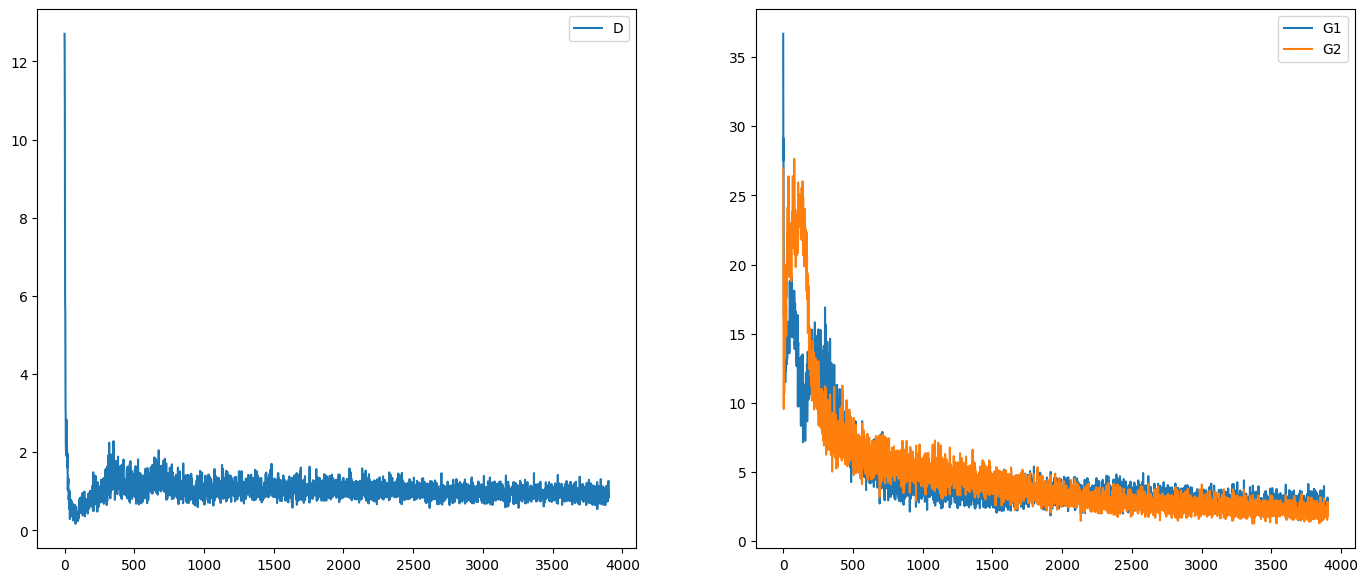

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(17, 7))
axes = axes.flatten()

axes[0].plot(D_losses, label="D")
axes[0].legend()
axes[1].plot(G1_losses, label="G1")
axes[1].plot(G2_losses, label="G2")
axes[1].legend()